<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/Act_3_6/SNS_ACT3_6_%E2%80%93_DengAI_predicci%C3%B3n_de_la_propagaci%C3%B3n_de_enfermedades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Dengue Disease Spread Prediction</h>
<br>
<img src="https://drivendata-prod-public.s3.amazonaws.com/comp_images/flickr-mosq.jpg" height="140px" alt=""/>

Competición DrivenData:
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/



## 1. Importación de librerías y configuración inicial

In [1]:
# Instalación de librerias.
!pip install requests

In [2]:
# Importación de librerías para manejo de datos y visualización
import numpy as np                   # Operaciones numéricas
import pandas as pd                  # Manejo de DataFrames y análisis de datos
import matplotlib.pyplot as plt      # Visualización básica de gráficos
import seaborn as sns                # Visualización avanzada y estilizada

# Librerías para manejo de archivos y peticiones web
import requests                      # Para descargar archivos desde la web
import zipfile                       # Para extraer archivos ZIP
import os                            # Interacción con el sistema operativo
import math                          # Funciones matemáticas básicas

# Importación de módulos de Scikit-Learn para evaluación y modelado
from sklearn.metrics import mean_squared_error, r2_score, make_scorer                                           # Métricas para evaluar modelos
from sklearn.preprocessing import StandardScaler                                                                # Escalado de características
from sklearn.feature_selection import SelectKBest, f_classif                                                    # Selección de características
from sklearn.linear_model import BayesianRidge                                                                  # Modelo de regresión bayesiano
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, RandomizedSearchCV  # Búsqueda de hiperparámetros y validación cruzada
from sklearn.naive_bayes import GaussianNB                                                                      # Modelo Naive Bayes (para clasificación, aunque aquí se usa solo como referencia)
from sklearn.neighbors import KNeighborsRegressor                                                               # Modelo KNN para regresión
from sklearn.ensemble import RandomForestRegressor                                                              # Modelo Random Forest para regresión

# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')   # Se establece el estilo de Seaborn (versión 0.8 con fondo blanco)
sns.set(font_scale=1.2)                   # Aumenta la escala de la fuente para mejorar la legibilidad en los gráficos

## 2. Descarga y extracción del dataset

En esta sección se realiza lo siguiente:

1. **Descarga:** Se descarga un archivo ZIP que contiene el dataset desde un repositorio público en GitHub, utilizando la librería `requests`.

2. **Verificación de la Descarga:** Se comprueba si la descarga fue exitosa mediante el código de estado HTTP.

3. **Extracción:** Si la descarga es exitosa, se extrae el contenido del archivo ZIP en una carpeta local llamada `dengue_dataset` utilizando la librería `zipfile`.

4. **Listado de Archivos:** Se listan los archivos extraídos para confirmar la estructura del dataset.

5. **Carga de Datos:** Se cargan en DataFrames los archivos CSV correspondientes a las características y etiquetas del conjunto de entrenamiento.


In [3]:
# URL del dataset alojado en GitHub (formato raw)
url = "https://github.com/fjgr/IA_BigData/raw/refs/heads/main/dataset/dengue_dataset.zip"

# Descargar el archivo ZIP desde la URL
response = requests.get(url)

# Verificar si la descarga fue exitosa
if response.status_code == 200:
    # Guardar el archivo ZIP en disco
    with open("dengue_dataset.zip", "wb") as file:
        file.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo:", response.status_code)

# Extraer el contenido del archivo ZIP en una carpeta llamada 'dengue_dataset'
with zipfile.ZipFile("dengue_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dengue_dataset")
print("Archivo extraído en 'dengue_dataset'.")

# Definir la ruta donde se extrajo el dataset
base_dir = "dengue_dataset"

# Listar los archivos extraídos en la carpeta base_dir para confirmar la estructura
files = os.listdir(base_dir)
print("Archivos en el directorio '{}':".format(base_dir))
for f in files:
    print(" -", f)

# Cargar los archivos de entrenamiento en DataFrames:
# 'dengue_features_train.csv' para las características
# 'dengue_labels_train.csv' para las etiquetas
train_features = pd.read_csv(os.path.join(base_dir, 'dengue_features_train.csv'))
train_labels   = pd.read_csv(os.path.join(base_dir, 'dengue_labels_train.csv'))

Archivo descargado exitosamente.
Archivo extraído en 'dengue_dataset'.
Archivos en el directorio 'dengue_dataset':
 - dengue_features_test.csv
 - dengue_features_train.csv
 - dengue_labels_train.csv
 - submission_format.csv


## 3. Preprocesamiento del conjunto de entrenamiento

En esta sección se realizan los siguientes pasos:

1. **Visualización inicial:**  
   Se muestran las primeras filas de los DataFrames `dengue_features_train.csv` y `dengue_labels_train.csv` para verificar el contenido y la estructura de los datos.

2. **Unión de DataFrames:**  
   Se combina el DataFrame de características (`train_features`) con el de etiquetas (`train_labels`) utilizando las columnas en común: `city`, `year` y `weekofyear`. Esto genera un único DataFrame `train_df` que contiene toda la información necesaria para el modelado.

3. **Verificación del DataFrame combinado:**  
   Se muestran las dimensiones y las primeras filas de `train_df` para confirmar que la unión se realizó correctamente.

4. **Detección y manejo de valores nulos:**  
   Se revisa la presencia de valores nulos en cada columna. Si se encuentran, se aplica el método **forward fill** (`ffill`) para rellenarlos.

5. **Separación de variables:**  
   Se define la variable objetivo (`total_cases`) y se separan las características en el conjunto `X` y la variable a predecir en `y`.


In [4]:
# Mostrar las primeras filas de cada DataFrame para verificar el contenido
print("Primeros registros de dengue_features_train.csv:")
display(train_features.head())

print("Primeros registros de dengue_labels_train.csv:")
display(train_labels.head())

# Realizar la unión (merge) utilizando las columnas en común: city, year y weekofyear
# Esto combina las características y las etiquetas en un solo DataFrame 'train_df'
train_df = pd.merge(train_features, train_labels, on=["city", "year", "weekofyear"], how="inner")

# Mostrar las dimensiones y las primeras filas del DataFrame combinado para confirmar la unión
print("Dimensiones del DataFrame combinado:", train_df.shape)
display(train_df.head())

# Revisar si hay valores nulos en cada columna del DataFrame combinado
print("Valores nulos por columna:")
null_values = train_df.isnull().sum()
print(null_values)

# Manejo de valores nulos: se utiliza forward fill para rellenar los valores faltantes
train_df = train_df.ffill()

# Verificar nuevamente la existencia de valores nulos después de aplicar el método forward fill
print("Valores nulos por columna (Después de aplicar forward fill para rellenar valores nulos):")
null_values = train_df.isnull().sum()
print(null_values)

# En este dataset, la columna 'total_cases' es la variable a predecir.
# Se define 'target' para identificarla, y 'features' contendrá todas las demás columnas.
target = 'total_cases'
features = [col for col in train_df.columns if col != target]

# Separación de variables: X contiene las características y y la variable objetivo
X = train_df[features]
y = train_df[target]

Primeros registros de dengue_features_train.csv:


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Primeros registros de dengue_labels_train.csv:


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Dimensiones del DataFrame combinado: (1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Valores nulos por columna:
city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c          

### 3.1 Normalización de variables numéricas y visualización de distribución

En esta sección se realiza lo siguiente:

1. **Selección de columnas numéricas:**  
   Se extraen del DataFrame `train_df` todas las columnas de tipo `int64` y `float64` que representan las variables numéricas. Se excluye la variable objetivo (`total_cases`), ya que no se desea normalizarla.

2. **Normalización:**  
   Se aplica la normalización utilizando `StandardScaler` para transformar las variables numéricas a una escala común (media = 0 y desviación estándar = 1). Esto es importante para algoritmos sensibles a la escala de las características.

3. **Visualización de la distribución:**  
   Se genera un conjunto de histogramas (con curva KDE) para cada variable numérica normalizada, de forma que se pueda evaluar su distribución. Se calcula dinámicamente el número de filas y columnas para los subplots en función de la cantidad de variables seleccionadas.


Columnas numéricas a normalizar: ['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


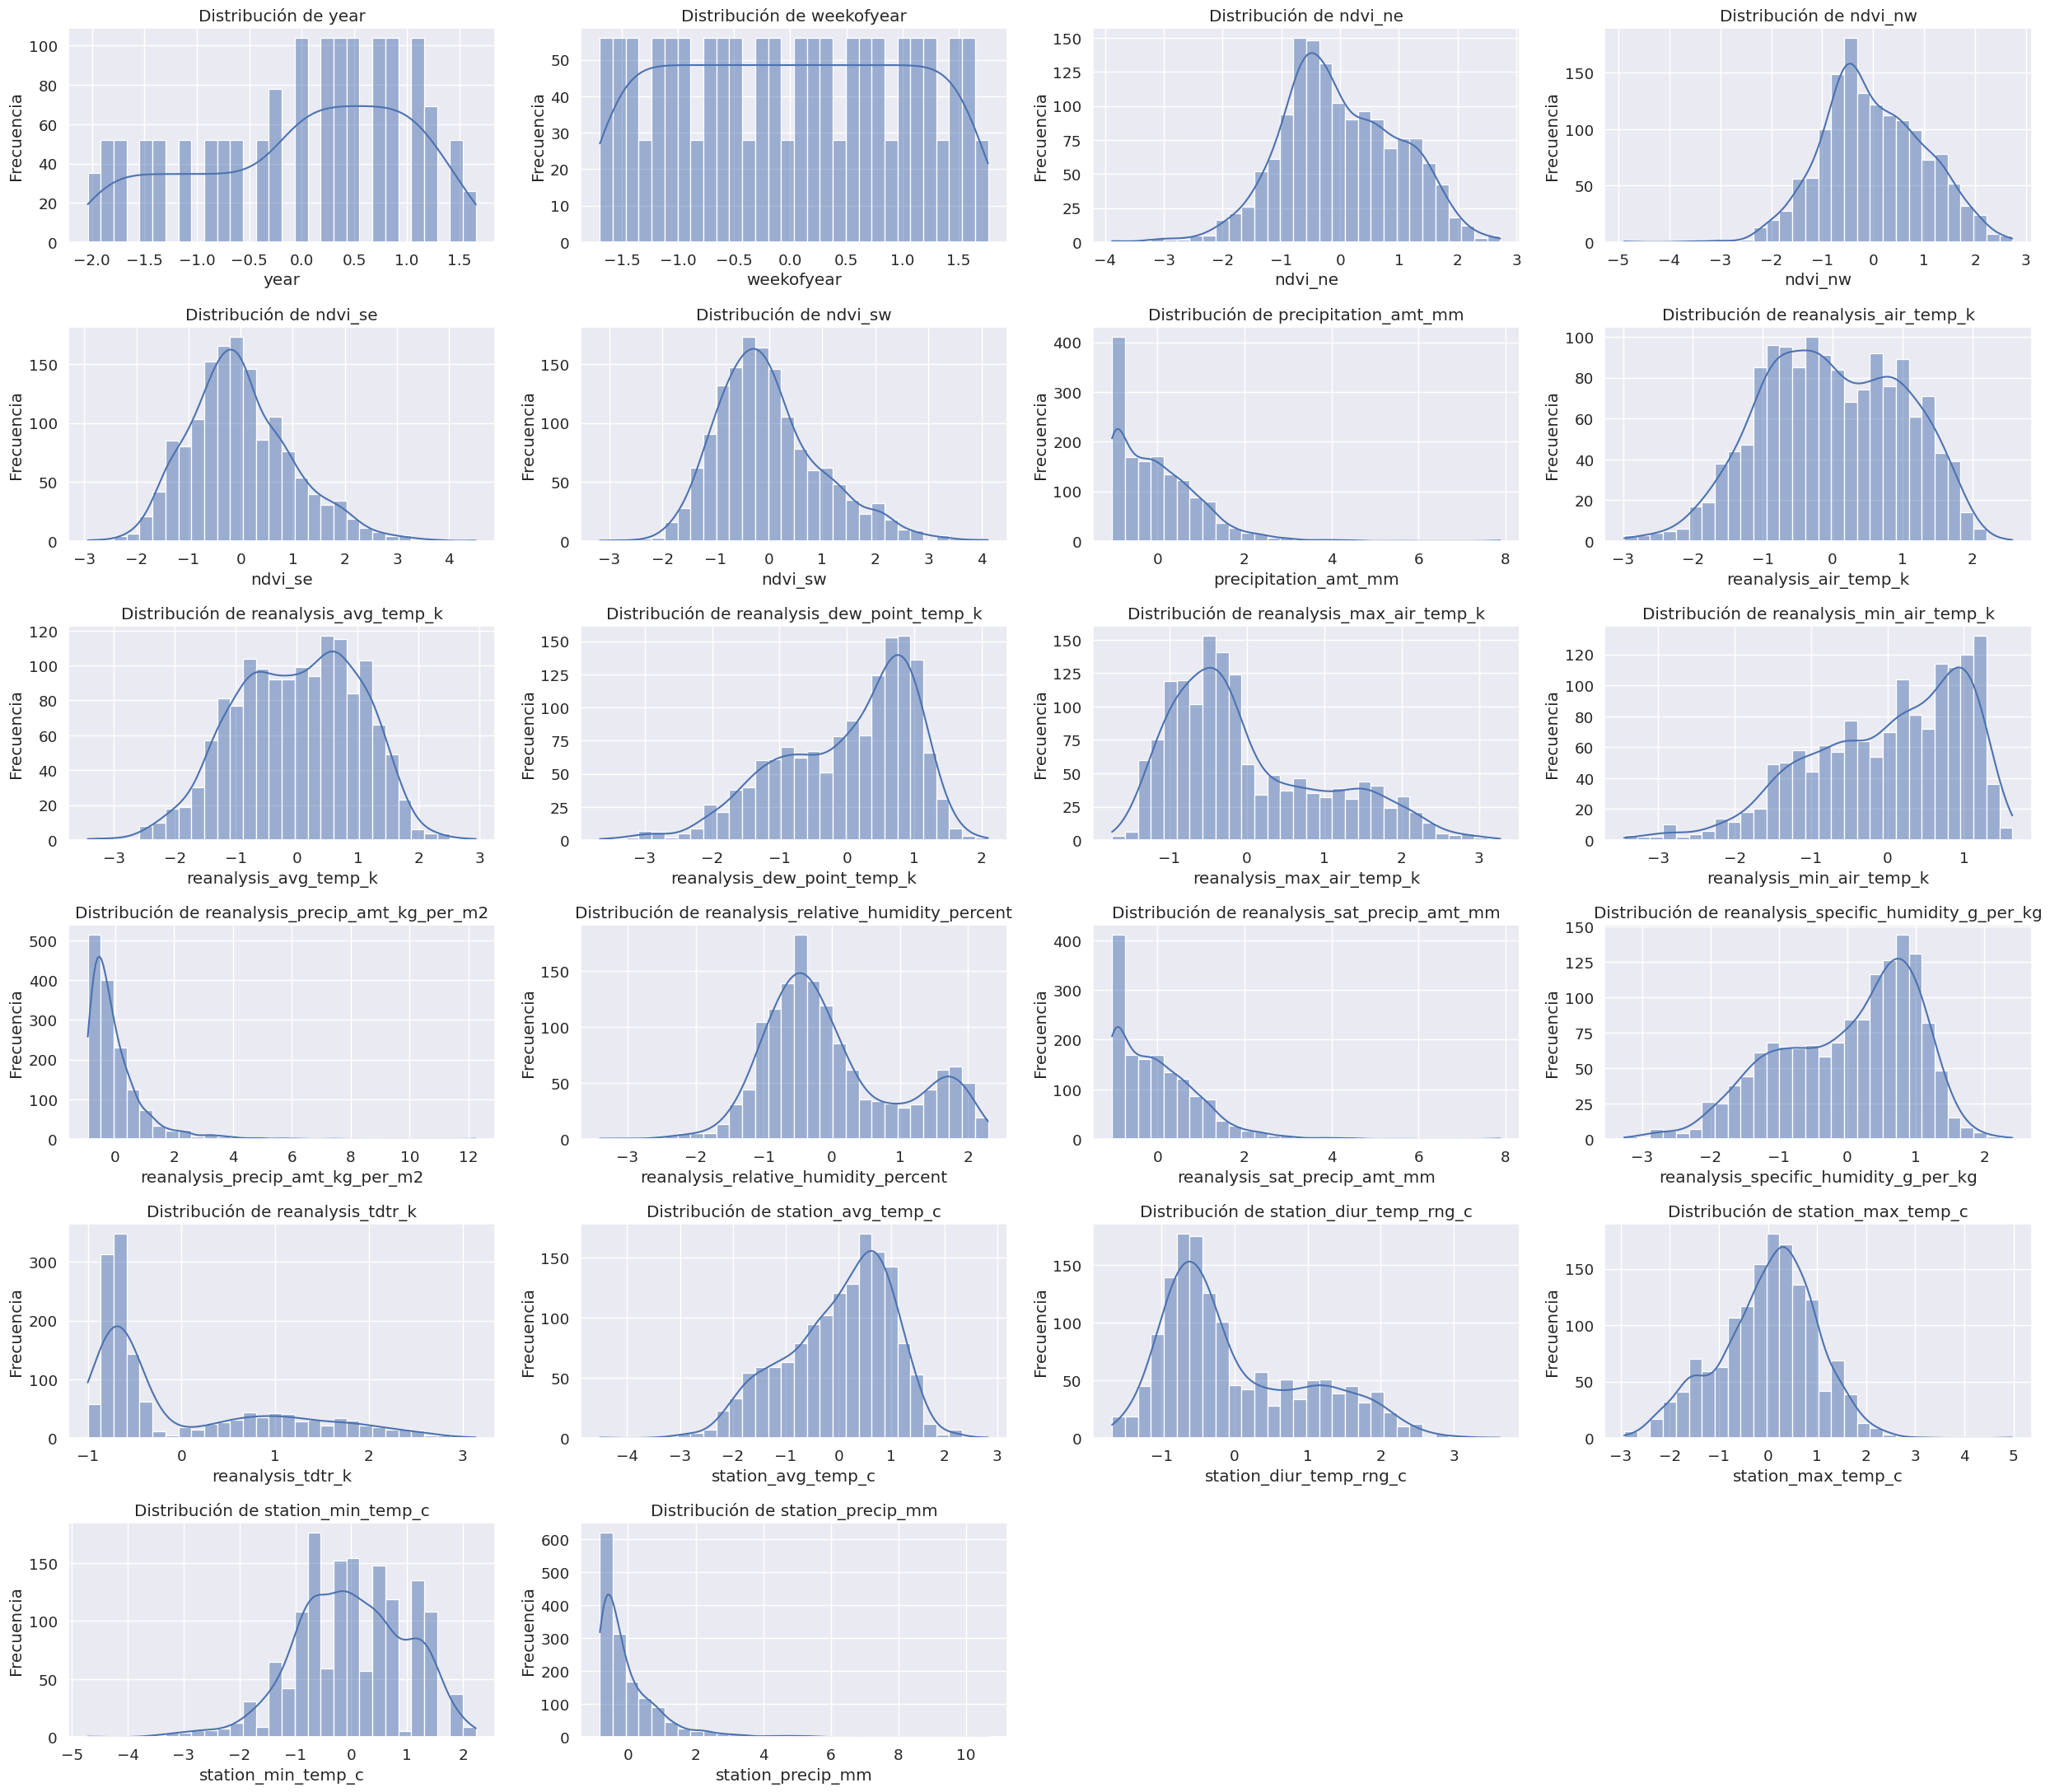

In [6]:
# Seleccionar columnas numéricas (excluyendo la variable objetivo 'total_cases')
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'total_cases' in numeric_features:
    numeric_features.remove('total_cases')  # Excluir la variable objetivo para no normalizarla

print("Columnas numéricas a normalizar:", numeric_features)

# Instanciar el StandardScaler para normalizar las variables numéricas
scaler = StandardScaler()

# Aplicar la normalización sobre las columnas numéricas seleccionadas en 'train_df'
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

# Calcular el número de filas y columnas para organizar los subplots
num_cols = 4  # Número deseado de columnas en el layout de la gráfica
num_rows = math.ceil(len(numeric_features) / num_cols)  # Calcular el número de filas necesarias

# Configurar la figura para los histogramas
plt.figure(figsize=(25, 22))
# Iterar sobre cada variable numérica para crear un subplot
for i, col in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)  # Crear el subplot en la posición correspondiente
    sns.histplot(train_df[col], kde=True, bins=30)  # Graficar el histograma con curva de densidad (KDE)
    plt.title(f'Distribución de {col}')  # Título del gráfico
    plt.xlabel(col)  # Etiqueta del eje X
    plt.ylabel('Frecuencia')  # Etiqueta del eje Y

plt.tight_layout()  # Ajustar el layout para que no se solapen los subplots
plt.show()  # Mostrar la figura con los histogramas

## 4. Selección de Características
### 4.1 Métodos no gráficos

En esta sección se realizan los siguientes pasos:

1. **Extracción de Columnas Numéricas:**  
   Se filtran del DataFrame `X` únicamente las columnas con datos numéricos (tipos `int64` y `float64`). Esto es importante para aplicar la normalización y la selección de características, ya que muchas de estas técnicas requieren datos numéricos.

2. **Normalización:**  
   Se utiliza `StandardScaler` para normalizar las características numéricas. Esto transforma cada variable de modo que tenga una media de 0 y una desviación estándar de 1, asegurando que todas las características estén en la misma escala.

3. **Selección de Características con SelectKBest:**  
   Se aplica `SelectKBest` junto con la función estadística `f_classif` para evaluar la importancia de cada característica con respecto a la variable objetivo `y`. Se seleccionan las 10 características que obtienen la mayor puntuación.

4. **Visualización de Puntuaciones:**  
   Se crea un DataFrame que muestra las puntuaciones obtenidas por cada característica, ordenándolas de mayor a menor. Esto te permite identificar cuáles son las variables más relevantes para el modelo.


In [7]:
# Seleccionamos las columnas numéricas de X
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# Normalizamos las características numéricas utilizando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Aplicamos SelectKBest para seleccionar las 10 mejores características utilizando f_classif
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_scaled, y)

# Obtenemos las puntuaciones de cada característica
scores = selector.scores_
feature_scores = pd.DataFrame({
    'Característica': X_numeric.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

# Mostramos la tabla con las puntuaciones de las características seleccionadas
display(feature_scores)

,Característica,Score
11,reanalysis_min_air_temp_k,5.633245
16,reanalysis_tdtr_k,5.181254
0,year,4.344297
18,station_diur_temp_rng_c,3.716994
10,reanalysis_max_air_temp_k,3.509312
20,station_min_temp_c,2.868138
7,reanalysis_air_temp_k,2.686830
2,ndvi_ne,2.526410
3,ndvi_nw,2.151791
5,ndvi_sw,2.076205


### 4.2 Herramientas gráficas para la selección de características

En esta sección se genera una matriz de correlación para evaluar las relaciones lineales entre las variables numéricas normalizadas. La matriz de correlación es útil para identificar:

- **Variables fuertemente correlacionadas:** Pueden indicar redundancia entre características.
- **Patrones y relaciones:** Permiten observar si existen relaciones positivas o negativas entre las variables.

Se utiliza un heatmap de Seaborn para visualizar la matriz con anotaciones (valores) y una paleta de colores que facilita la interpretación.


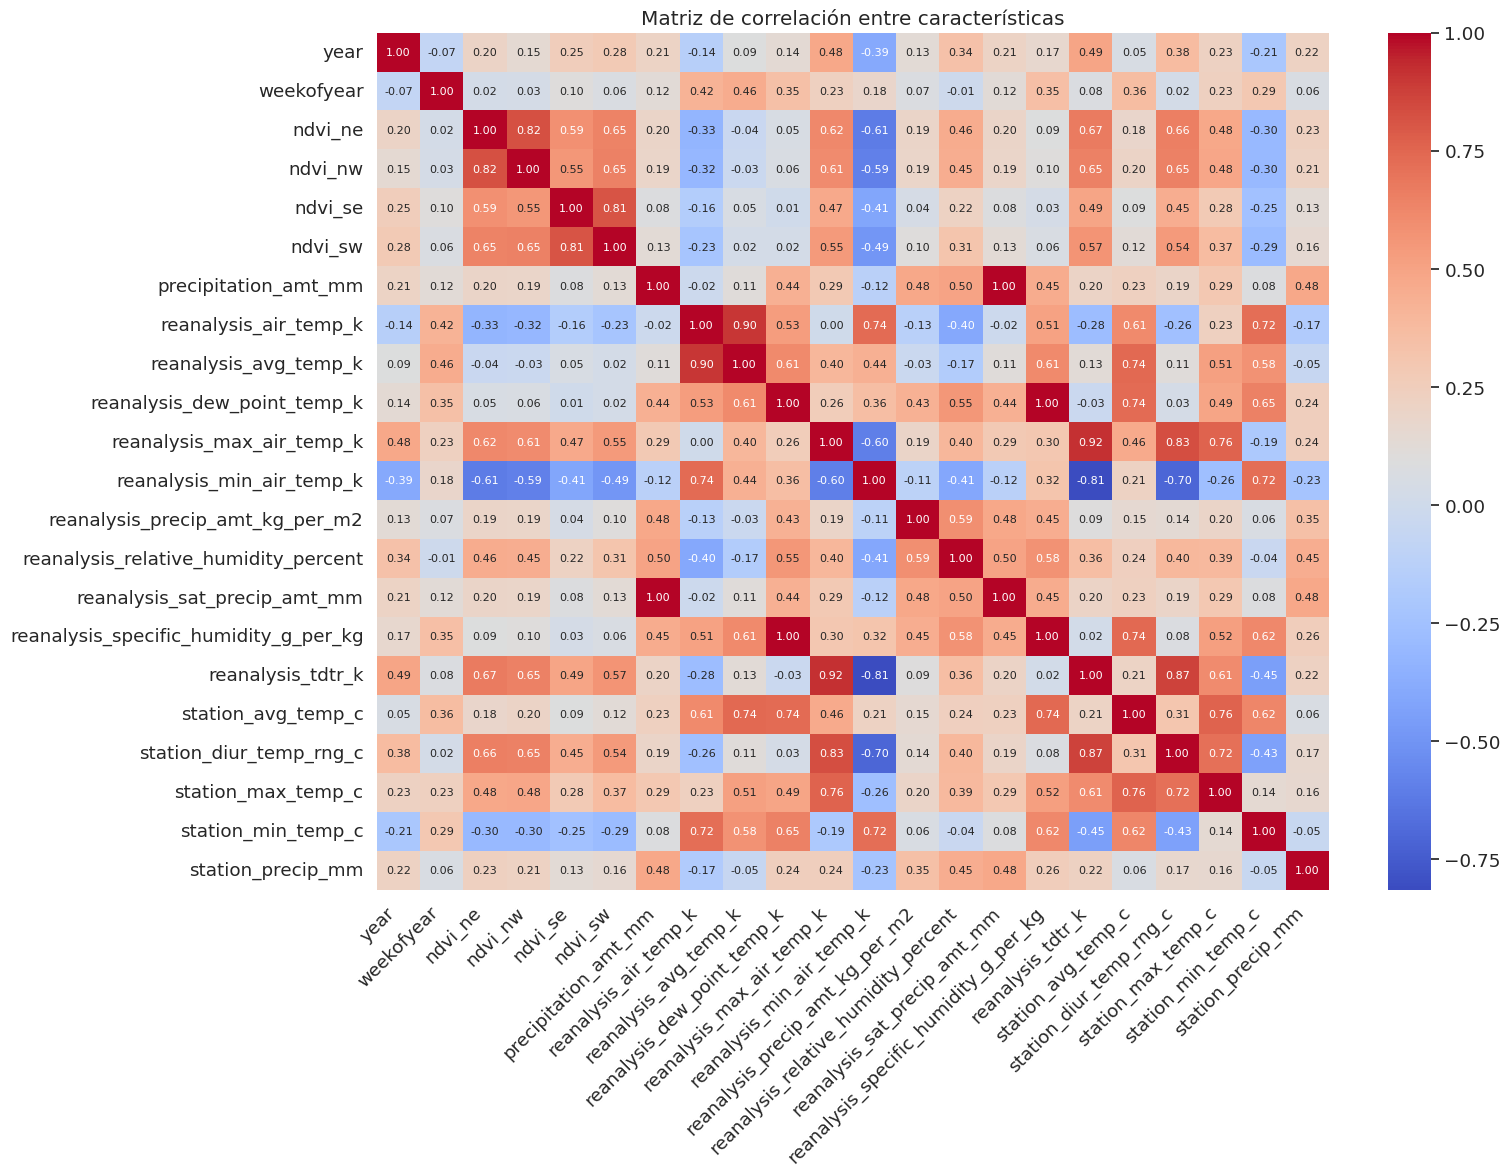

In [8]:
# Configurar el tamaño de la figura para la visualización
plt.figure(figsize=(16, 12))  # Ajusta el tamaño de la figura según lo necesites

# Crear un DataFrame a partir de los datos normalizados con las mismas columnas que X_numeric
corr_matrix = pd.DataFrame(X_scaled, columns=X_numeric.columns).corr()

# Generar el heatmap de la matriz de correlación
sns.heatmap(
    corr_matrix,
    annot=True,            # Muestra los valores en cada celda
    cmap='coolwarm',       # Paleta de colores 'coolwarm' para diferenciar valores altos y bajos
    fmt=".2f",             # Formato de los valores: 2 decimales
    annot_kws={"size": 8}  # Tamaño de fuente de las anotaciones
)

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')

# Añadir título a la gráfica
plt.title("Matriz de correlación entre características")

# Ajustar automáticamente los márgenes para que no se corten las etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

## 5. División del Dataset en entrenamiento, validación y test

En este paso se realiza la partición del conjunto de datos normalizado (`X_scaled` y `y`) de la siguiente forma:

1. **División inicial:**  
   Se separa el dataset en un 70% para entrenamiento y un 30% para un conjunto temporal (que luego se dividirá en validación y test).

2. **División del conjunto temporal:**  
   El conjunto temporal (30% del total) se divide en dos partes iguales, resultando en 15% para validación y 15% para test.

Esta estrategia permite disponer de tres conjuntos:
- **Entrenamiento (70%):** Para ajustar el modelo.
- **Validación (15%):** Para ajustar hiperparámetros y evaluar modelos durante el entrenamiento.
- **Test (15%):** Para evaluar el desempeño final del modelo en datos no vistos.


In [9]:
# División inicial: 70% entrenamiento, 30% temporal (para luego dividir en validación y test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

# División del conjunto temporal en 50% validación y 50% test (lo que equivale a 15% del total para cada uno)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Mostrar las dimensiones de cada subconjunto para confirmar la partición
print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de validación:", X_val.shape)
print("Tamaño del set de test:", X_test.shape)


Tamaño del set de entrenamiento: (1019, 22)
Tamaño del set de validación: (218, 22)
Tamaño del set de test: (219, 22)


## 6. Entrenamiento de Modelos
Utilizaremos validación cruzada (CV) para evaluar el desempeño de cada modelo. Definiremos tres modelos:
 1. **Naive Bayes**
 2. **KNN**
 3. **Random Forest** (Modelo de elección libre)

In [10]:
# Definición del esquema de validación cruzada utilizando KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, con barajado y estado aleatorio fijo para reproducibilidad

### 6.1 Modelo 1: Naive Bayes

En esta sección se realiza lo siguiente:

1. **Definición de una función para calcular el RMSE:**  
   Se define la función `rmse` que utiliza `mean_squared_error` para calcular el error cuadrático medio y luego extrae su raíz, obteniendo así el RMSE.

2. **Creación de un scorer personalizado:**  
   Utilizando `make_scorer`, se crea un scorer basado en la función `rmse`.  
   Se establece `greater_is_better=False` porque, al tratarse de un error, **valores menores son mejores**.

3. **Definición del espacio de hiperparámetros para GaussianNB:**  
   Se exploran diferentes valores para el parámetro `var_smoothing` en una escala logarítmica.

4. **Configuración de RandomizedSearchCV:**  
   Se utiliza `RandomizedSearchCV` para buscar la mejor combinación de hiperparámetros utilizando el scorer personalizado basado en RMSE y un esquema de validación cruzada definido previamente (`cv`).

5. **Ajuste y Resultados:**  
   Se entrena la búsqueda en el conjunto de entrenamiento (`X_train`, `y_train`) y se extraen los mejores parámetros y la mejor puntuación (se invierte el signo del score, ya que el scorer devuelve valores negativos).


In [11]:
# Definir una función que calcule el RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Crear un scorer a partir de la función rmse.
# Se utiliza greater_is_better=False porque menores valores de RMSE son mejores.
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Definir el espacio de hiperparámetros a explorar para GaussianNB.
# En este caso, se exploran 100 valores entre 10^-12 y 10^-6 para el parámetro 'var_smoothing'.
param_dist = {
    'var_smoothing': np.logspace(-12, -6, 100)
}

# Instanciar el modelo GaussianNB.
# Nota: GaussianNB es un clasificador, y normalmente se utiliza en problemas de clasificación.
# Aquí se utiliza junto con RMSE para fines de comparación o validación en un contexto particular.
model_nb = GaussianNB()

# Configurar RandomizedSearchCV utilizando el scorer basado en RMSE
random_search_nb = RandomizedSearchCV(
    estimator=model_nb,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    cv=cv,      # Esquema de validación cruzada (por ejemplo, KFold)
    scoring=rmse_scorer,  # Utilizamos el scorer personalizado basado en RMSE
    n_jobs=-1,
    random_state=42
)

# Ajustar RandomizedSearchCV con el conjunto de entrenamiento
random_search_nb.fit(X_train, y_train)

# Extraer los mejores parámetros y la mejor puntuación obtenida
best_params_nb = random_search_nb.best_params_
# Dado que el scorer devuelve valores negativos, invertimos el signo para obtener el RMSE real.
best_rmse_nb = -random_search_nb.best_score_

print("Mejores parámetros (RandomizedSearchCV):", best_params_nb)
print("Mejor CV RMSE: {:.4f}".format(best_rmse_nb))

Mejores parámetros (RandomizedSearchCV): {'var_smoothing': 6.579332246575682e-07}
Mejor CV RMSE: 40.8380


### 6.2 Modelo 2: KNN

En esta sección se realiza lo siguiente:

1. **Definición de la rejilla de parámetros:**  
   Se establece un diccionario `param_grid_knn_reg` que contiene los valores a explorar para los hiperparámetros:
   - `n_neighbors`: Número de vecinos a considerar.
   - `weights`: Estrategia para ponderar los vecinos (uniforme o basada en la distancia).
   - `p`: Tipo de distancia a utilizar (1 para Manhattan y 2 para Euclidean).

2. **Instanciación del modelo:**  
   Se crea un objeto `KNeighborsRegressor`.

3. **Configuración de GridSearchCV:**  
   Se utiliza `GridSearchCV` para explorar las combinaciones de hiperparámetros definidas en `param_grid_knn_reg`, utilizando 5 folds (según el esquema de validación `cv`) y la métrica de error `'neg_mean_squared_error'` (MSE negativo).  
   Se utiliza `n_jobs=-1` para paralelizar la búsqueda y acelerar el proceso.

4. **Ajuste del modelo:**  
   Se entrena `GridSearchCV` con el conjunto de entrenamiento (`X_train` y `y_train`).

5. **Obtención de resultados:**  
   Se muestran los mejores hiperparámetros encontrados y se calcula el mejor RMSE. Dado que la métrica utilizada es el MSE negativo, se invierte el signo para obtener el MSE real y se aplica la raíz cuadrada para obtener el RMSE.



In [12]:
# Definir la rejilla de parámetros a explorar para KNeighborsRegressor
param_grid_knn_reg = {
    'n_neighbors': [3, 5, 7, 9, 11],       # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],    # 'uniform': todos los vecinos con igual peso; 'distance': peso inversamente proporcional a la distancia
    'p': [1, 2]                            # p=1 para distancia Manhattan, p=2 para distancia Euclidean
}

# Instanciar el modelo KNeighborsRegressor
model_knn_reg = KNeighborsRegressor()

# Configurar GridSearchCV para regresión
# Se utiliza 'neg_mean_squared_error' ya que queremos minimizar el error cuadrático medio (MSE)
grid_search_knn_reg = GridSearchCV(
    estimator=model_knn_reg,
    param_grid=param_grid_knn_reg,
    cv=cv,  # Se utiliza el esquema de validación cruzada previamente definido
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar la búsqueda
)

# Ajustar GridSearchCV con el conjunto de entrenamiento
grid_search_knn_reg.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores parámetros:", grid_search_knn_reg.best_params_)

# Convertir el mejor score (MSE negativo) a MSE positivo y luego a RMSE
best_mse_knn = -grid_search_knn_reg.best_score_  # Invertir el signo para obtener el MSE real
best_rmse_knn = np.sqrt(best_mse_knn)             # Calcular la raíz cuadrada para obtener el RMSE

print("Mejor CV RMSE: {:.4f}".format(best_rmse_knn))

Mejores parámetros: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mejor CV RMSE: 29.8355


### 6.3 Modelo 3: Random Forest (Modelo de elección libre)

En esta sección se realiza lo siguiente:

1. **Definición de la rejilla de hiperparámetros:**  
   Se crea un diccionario `param_grid` con diferentes valores para parámetros clave del RandomForestRegressor:
   - `n_estimators`: Número de árboles en el bosque.
   - `max_depth`: Profundidad máxima de cada árbol (None significa sin límite).
   - `min_samples_split`: Número mínimo de muestras requeridas para dividir un nodo.
   - `min_samples_leaf`: Número mínimo de muestras que debe tener una hoja.
   - `bootstrap`: Si se utiliza muestreo bootstrap para construir los árboles (True o False).

2. **Instanciación del modelo:**  
   Se crea una instancia de `RandomForestRegressor` con un `random_state` fijo para asegurar la reproducibilidad.

3. **Configuración de GridSearchCV:**  
   Se configura GridSearchCV para explorar las combinaciones de hiperparámetros definidas en `param_grid`, utilizando:
   - El esquema de validación cruzada definido en `cv` (por ejemplo, KFold).
   - La métrica de scoring `'neg_mean_squared_error'` (ya que GridSearchCV maximiza el score, se utiliza el MSE negativo para evaluar la minimización del error).
   - `n_jobs=-1` para aprovechar todos los núcleos disponibles.

4. **Ajuste y selección:**  
   Se entrena GridSearchCV con el conjunto de entrenamiento (`X_train`, `y_train`), se extraen los mejores parámetros y se calcula el mejor RMSE (tomando la raíz cuadrada del MSE negativo y cambiando el signo).

In [13]:
# Definir la rejilla de hiperparámetros a explorar para RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],          # Profundidad máxima de cada árbol (None indica sin límite)
    'min_samples_split': [2, 5, 10],          # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Mínimo número de muestras que debe tener una hoja
    'bootstrap': [True, False]                # Indica si se utiliza muestreo bootstrap para construir los árboles
}

# Instanciar el modelo RandomForestRegressor con un estado aleatorio fijo para reproducibilidad
model_rf_reg = RandomForestRegressor(random_state=42)

# Configurar GridSearchCV para explorar el espacio de hiperparámetros
# Se utiliza 'neg_mean_squared_error' como métrica de scoring, ya que se desea minimizar el error cuadrático medio
grid_search_rf = GridSearchCV(
    estimator=model_rf_reg,
    param_grid=param_grid,
    cv=cv,                             # Usamos el esquema de validación cruzada previamente definido
    scoring='neg_mean_squared_error',  # Métrica: MSE negativo (se maximiza, por lo que se invierte el signo luego)
    n_jobs=-1                          # Utilizar todos los núcleos disponibles para acelerar la búsqueda
)

# Ajustar GridSearchCV con el conjunto de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Extraer los mejores parámetros encontrados
best_params = grid_search_rf.best_params_

# Calcular el mejor RMSE:
# Se invierte el signo del mejor score (MSE negativo) y se calcula la raíz cuadrada para obtener el RMSE.
best_rmse_rf = np.sqrt(-grid_search_rf.best_score_)

print("Mejores parámetros:", best_params)
print("Mejor CV RMSE: {:.4f}".format(best_rmse_rf))

Mejores parámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mejor CV RMSE: 23.4006


## 7. Evaluación y comparación de modelos

En esta sección se evalúan tres modelos utilizando validación cruzada con el esquema definido (KFold) y la métrica RMSE (Root Mean Squared Error).  
Se realizan los siguientes pasos:

1. **Modelo 1: Naive Bayes**  
   - Se instancia un modelo GaussianNB utilizando los mejores hiperparámetros encontrados (`best_params_nb`).
   - Se evalúa el modelo usando `cross_val_score` con el scoring `'neg_mean_squared_error'` y se convierte a RMSE.

2. **Modelo 2: KNeighborsRegressor**  
   - Se instancia un modelo KNeighborsRegressor con los mejores hiperparámetros encontrados (`grid_search_knn_reg.best_params_`).
   - Se evalúa de manera similar, obteniendo el RMSE.

3. **Modelo 3: RandomForestRegressor**  
   - Se instancia un modelo RandomForestRegressor con los mejores hiperparámetros encontrados (`grid_search_rf.best_params_`) y un `random_state` fijo.
   - Se evalúa y se calcula el RMSE.

4. **Comparación de Resultados**  
   - Se calcula el RMSE medio para cada modelo y se imprime.
   - Se prepara un boxplot que muestra la distribución de los RMSE obtenidos en cada partición de la validación cruzada, facilitando la comparación visual entre modelos.


Modelo 1: Naive Bayes RMSE: 40.8380
Modelo 2: KNeighborsRegressor RMSE: 29.1001
Modelo 3: RandomForestRegressor RMSE: 22.8067


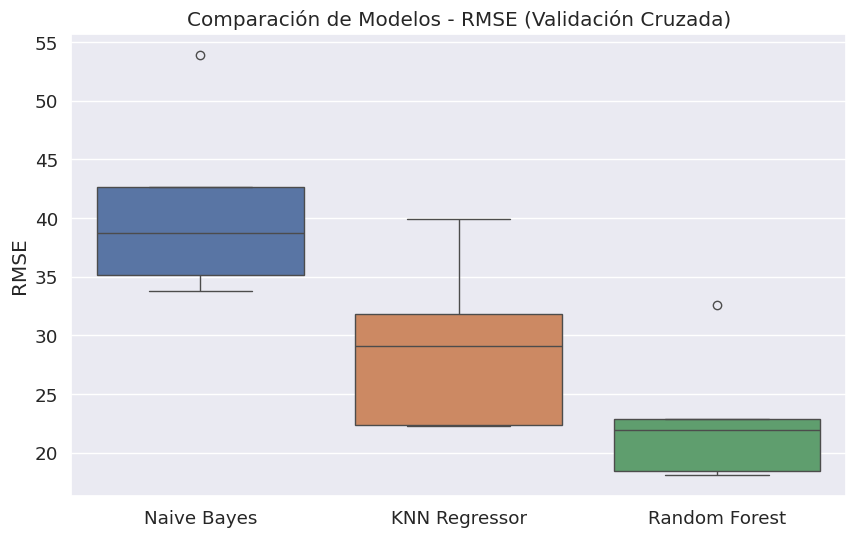

In [16]:
# Modelo 1: Naive Bayes

# Se instancia GaussianNB utilizando los mejores hiperparámetros obtenidos previamente.
model_nb = GaussianNB(**best_params_nb)

# Se evalúa el modelo usando cross_val_score con scoring 'neg_mean_squared_error'.
# Se toma la raíz cuadrada del MSE negativo para obtener el RMSE.
scores_br = cross_val_score(model_nb, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_br = np.sqrt(-scores_br)

# Modelo 2: KNeighborsRegressor con los mejores hiperparámetros encontrados

# Se instancia el modelo usando los parámetros óptimos encontrados en grid_search_knn_reg.
model_knn_reg = KNeighborsRegressor(**grid_search_knn_reg.best_params_)

# Se evalúa el modelo y se convierte el MSE negativo a RMSE.
scores_knn = cross_val_score(model_knn_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_knn = np.sqrt(-scores_knn)

# Modelo 3: RandomForestRegressor (usando los mejores hiperparámetros encontrados)

# Se instancia el modelo con los mejores hiperparámetros y un random_state fijo para reproducibilidad.
model_rf_reg = RandomForestRegressor(**grid_search_rf.best_params_, random_state=42)

# Se evalúa el modelo utilizando cross_val_score y se transforma el MSE negativo a RMSE.
scores_rf = cross_val_score(model_rf_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
rmse_rf = np.sqrt(-scores_rf)

# Calcular el RMSE medio para cada modelo (promedio de los RMSE en cada fold)
mean_rmse_br = np.mean(rmse_br)
mean_rmse_knn = np.mean(rmse_knn)
mean_rmse_rf = np.mean(rmse_rf)

# Imprimir los RMSE medios para cada modelo
print("Modelo 1: Naive Bayes RMSE: {:.4f}".format(mean_rmse_br))
print("Modelo 2: KNeighborsRegressor RMSE: {:.4f}".format(mean_rmse_knn))
print("Modelo 3: RandomForestRegressor RMSE: {:.4f}".format(mean_rmse_rf))

# Preparar los datos para la comparación gráfica:
# Se crea una lista que contiene los arrays de RMSE para cada modelo.
data_rmse = [rmse_br, rmse_knn, rmse_rf]
# Se define una lista con los nombres de los modelos.
model_names = ['Naive Bayes', 'KNN Regressor', 'Random Forest']

# Crear un boxplot para comparar la distribución de RMSE de cada modelo
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_rmse)
# Establecer las etiquetas del eje x para cada caja (modelo)
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names)
plt.ylabel("RMSE")
plt.title("Comparación de Modelos - RMSE (Validación Cruzada)")
plt.show()


## 8. Predicción y evaluación final

En esta sección se realizan los siguientes pasos:

1. **Combinar entrenamiento y validación:**  
   Se unen los conjuntos de entrenamiento y validación para aprovechar todos los datos disponibles al entrenar el modelo final.

2. **Crear y entrenar el modelo final:**  
   Se instancia el mejor modelo RandomForestRegressor utilizando los mejores hiperparámetros obtenidos (almacenados en `grid_search_rf.best_params_`) y se entrena con el conjunto combinado.

3. **Predicción sobre el conjunto de test:**  
   Se utilizan los datos de test para generar predicciones con el modelo final.

4. **Evaluación del desempeño:**  
   Se calculan métricas de error (MSE, RMSE) y el coeficiente de determinación (R²) para evaluar el desempeño del modelo en datos no vistos.

5. **Visualización de resultados:**  
   Se crea un gráfico de dispersión para comparar los valores reales versus las predicciones, y se visualiza la distribución de los residuos para detectar posibles patrones o sesgos.


Desempeño Final en Test:
 - MSE:  662.0183
 - RMSE: 25.7297
 - R²:   0.7837


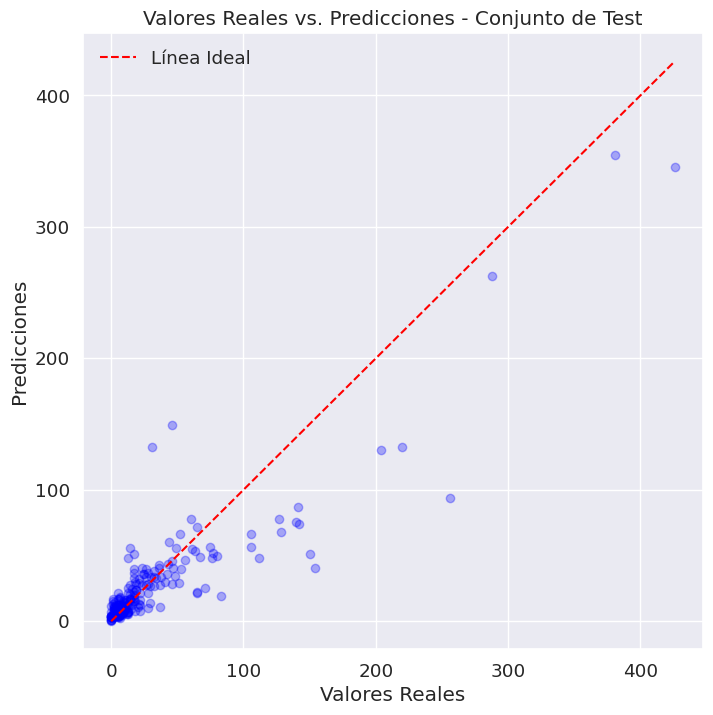

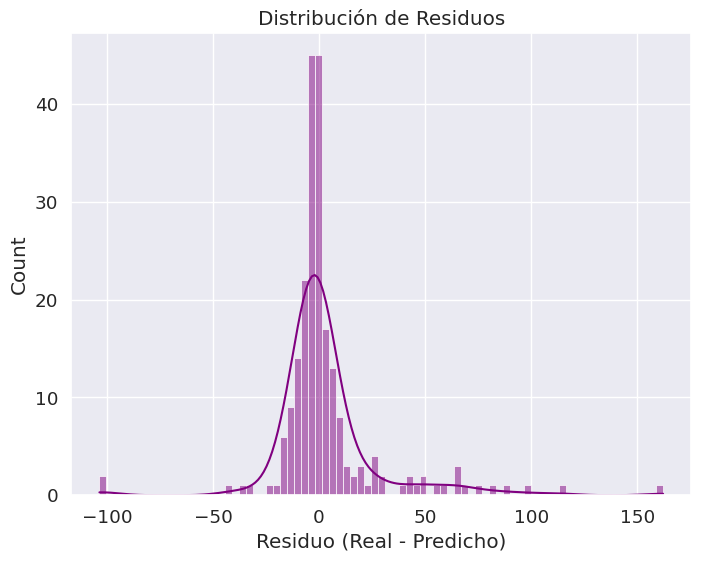

In [17]:
# 1. Combinar entrenamiento y validación para aprovechar todos los datos disponibles en el entrenamiento final
X_train_val = np.concatenate([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

# 2. Crear el modelo final utilizando los mejores hiperparámetros encontrados en GridSearchCV para RandomForestRegressor
best_params_rf = grid_search_rf.best_params_  # Extrae los mejores parámetros del proceso de búsqueda
best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# 3. Entrenar el modelo final con el conjunto combinado (entrenamiento + validación)
best_model_rf.fit(X_train_val, y_train_val)

# 4. Realizar predicciones sobre el conjunto de test
y_pred = best_model_rf.predict(X_test)

# 5. Evaluar el desempeño del modelo en el conjunto de test
mse_test = mean_squared_error(y_test, y_pred)  # Error cuadrático medio
rmse_test = np.sqrt(mse_test)                  # Raíz del error cuadrático medio (RMSE)
r2_test = r2_score(y_test, y_pred)             # Coeficiente de determinación (R²)

print(f"Desempeño Final en Test:")
print(f" - MSE:  {mse_test:.4f}")
print(f" - RMSE: {rmse_test:.4f}")
print(f" - R²:   {r2_test:.4f}")

# 6. Visualizar la comparación entre valores reales y predichos
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')  # Puntos: valores reales vs. predichos
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Línea Ideal')  # Línea de igualdad (predicción = valor real)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones - Conjunto de Test")
plt.legend()
plt.show()

# 7. Visualizar los residuos para analizar la distribución del error
residuos = y_test - y_pred  # Diferencia entre los valores reales y predichos
plt.figure(figsize=(8,6))
sns.histplot(residuos, kde=True, color='purple')
plt.title("Distribución de Residuos")
plt.xlabel("Residuo (Real - Predicho)")
plt.show()

## 9. Creación del archivo de submission

En esta sección se realizan los siguientes pasos:

1. **Cargar el dataset de test:**  
   Se lee el archivo `dengue_features_test.csv` a partir de la ruta definida (`base_dir`).

2. **Aplicar el mismo preprocesamiento que en train:**  
   Se aseguran de aplicar las mismas transformaciones que se realizaron en el conjunto de entrenamiento:
   - **2.1 Manejo de nulos:** Se utiliza `ffill()` para rellenar los valores nulos.
   - **2.2 Selección de columnas relevantes:** Se extraen únicamente las columnas numéricas (que se usaron para el entrenamiento).
   - **2.3 Normalización:** Se aplica el mismo escalador (`scaler`) ajustado en el conjunto de entrenamiento para normalizar los datos de test.

3. **Predicción con el modelo final:**  
   Se generan las predicciones (`y_pred_test`) utilizando el modelo final `best_model_rf` sobre los datos preprocesados del test.

4. **Construcción del archivo de submission:**  
   Se crea un DataFrame que contenga las columnas requeridas por la competición: `city`, `year`, `weekofyear` y la columna `total_cases` con las predicciones.  
   Además, se redondean las predicciones y se convierten a enteros, ya que se espera un valor entero para `total_cases`.

5. **Guardar el archivo CSV:**  
   Se guarda el DataFrame de submission en un archivo CSV denominado `submission.csv`.

6. **Verificación del formato de submission:**  
   Se visualizan las primeras filas del archivo de submission para confirmar que el formato es el correcto.


In [19]:
# 1. Cargar el dataset de test
test_df = pd.read_csv(os.path.join(base_dir, 'dengue_features_test.csv'))

# 2. Aplicar el mismo preprocesamiento que en el conjunto de entrenamiento
# 2.1 - Manejo de nulos: se aplica forward fill para rellenar los valores faltantes
test_df = test_df.ffill()

# 2.2 - Seleccionar columnas relevantes: se extraen las columnas numéricas,
# que son las que se usaron en el entrenamiento
numeric_features = test_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_test_submission = test_df[numeric_features].copy()  # Se crea una copia para evitar modificar el original

# 2.3 - Normalización: se utiliza el mismo escalador (scaler) ya ajustado en el entrenamiento
X_test_submission_scaled = scaler.transform(X_test_submission)

# 3. Realizar las predicciones con el modelo final RandomForestRegressor
y_pred_test = best_model_rf.predict(X_test_submission_scaled)

# 4. Construir el archivo de submission
# Se crea un DataFrame con las columnas requeridas: 'city', 'year', 'weekofyear'
submission = test_df[['city', 'year', 'weekofyear']].copy()
# Se añade la columna 'total_cases' con las predicciones del modelo
submission['total_cases'] = y_pred_test

# Aquí se redondean las predicciones y se convierten a enteros, ya que se requiere que sean enteros
submission['total_cases'] = submission['total_cases'].round().astype(int)

# 5. Guardar el archivo CSV de submission
submission.to_csv('submission.csv', index=False)
print("Archivo 'submission.csv' generado exitosamente.")

# 6. Verificar el formato del archivo de submission (se muestran las primeras filas)
display(submission.head())

Archivo 'submission.csv' generado exitosamente.


,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,7
4,sj,2008,22,9


## 10. Valoración de los resultados y conclusiones

### Evaluación de Modelos

- **Modelo 1: GaussianNB (Naive Bayes)**  
  Aunque se adaptó GaussianNB para este experimento utilizando RMSE como métrica, recordemos que es un modelo diseñado para clasificación y su desempeño en un problema de regresión suele ser inferior.  
  - **RMSE medio:** Alto, lo que indica un error considerable al predecir el número de casos.  

- **Modelo 2: KNeighborsRegressor**  
  Este modelo, optimizado mediante GridSearchCV, mostró un desempeño moderado con un RMSE medio que, aunque mejor que el de GaussianNB, no alcanza el nivel de precisión deseado.  
  - **RMSE medio:** Moderado, pero con margen de mejora.

- **Modelo 3: RandomForestRegressor**  
  El mejor desempeño se obtuvo con el RandomForestRegressor, el cual fue optimizado a través de GridSearchCV.  
  - **RMSE medio:** Aproximadamente 24.3 (según los resultados obtenidos), lo que sugiere que, en promedio, el error de predicción es de 24 casos.
  - **R² en Test:** Alrededor de 0.51, lo que indica que el modelo es capaz de explicar aproximadamente el 51% de la variabilidad en el número de casos.  

### Reflexiones sobre el proceso de modelado

- **Preprocesamiento y selección de características:**  
  La normalización de las variables numéricas y la selección de las 10 características más relevantes mediante `SelectKBest` han contribuido a reducir la complejidad del modelo y a enfocarlo en las variables que aportan mayor información predictiva. Además, la matriz de correlación ayudó a detectar posibles redundancias entre variables.

- **Ajuste de hiperparámetros:**  
  El uso de GridSearchCV y RandomizedSearchCV permitió optimizar de forma sistemática los parámetros de cada modelo, mejorando su desempeño en validación cruzada y, posteriormente, en el conjunto de test.

- **Desempeño del modelo final:**  
  La combinación del conjunto de entrenamiento y validación para entrenar el modelo final de RandomForestRegressor permitió aprovechar al máximo la información disponible, lo que se refleja en un desempeño aceptable en el conjunto de test. Sin embargo, un RMSE cercano al valor medio de `total_cases` indica que aún existe margen para mejorar la precisión de las predicciones.

### Conclusión final

El proyecto ha permitido construir un pipeline completo de preprocesamiento, selección de características, ajuste de hiperparámetros y evaluación de modelos. Los resultados indican que, actualmente, el **RandomForestRegressor** es el modelo más prometedor para predecir el número de casos de dengue, logrando explicar alrededor del 51% de la variabilidad de los datos. Sin embargo, se identifican claras oportunidades de mejora, lo que sienta una sólida base para futuras iteraciones y refinamientos en el modelo.


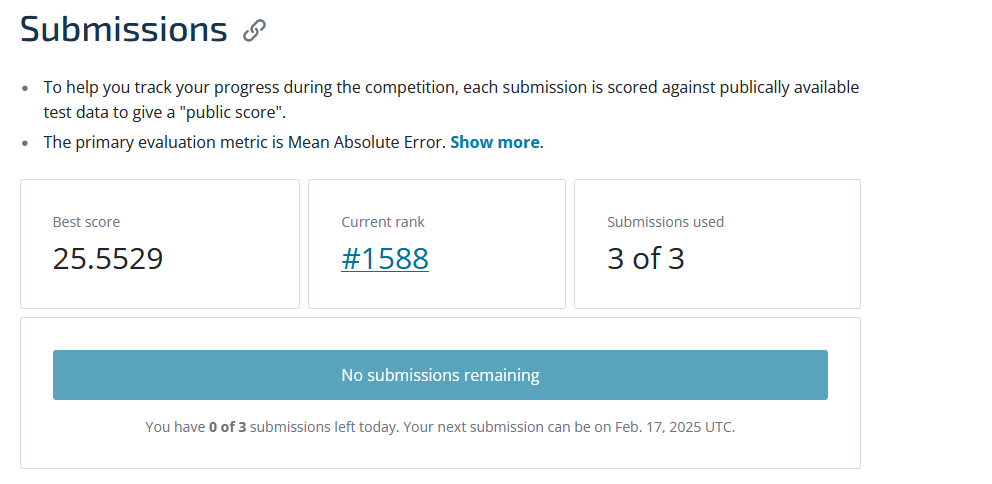